In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, normalize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
tf.__version__

'2.6.0'

In [23]:
train_df = pd.read_csv(os.path.join('data', 'unionTrain.csv'))
test_df = pd.read_csv(os.path.join('data', 'unionTest.csv'))
print(f"Length Train: {len(train_df)}")
print(f"Length Test: {len(test_df)}")

Length Train: 107
Length Test: 19


In [24]:
X_train, y_train = train_df.drop(['Severity', 'sequence_id'], axis=1), train_df['Severity']
X_test, y_test = test_df.drop(['Severity', 'sequence_id'], axis=1), test_df['Severity']

In [25]:
X_train.head()
min(X_train.min()), max(X_train.max())

(0.0, 514.672607421875)

In [26]:
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"Max: {X_train.max()}, Min: {X_train.min()}")
def modify_X(x):
    result = x.copy()
    result = result.reshape(-1, 21350//25, 50)
    return result
X_train_modified = modify_X(X_train)
X_test_modified = modify_X(X_test)
X_train_modified.shape, X_test_modified.shape

Max: 1.0, Min: 0.0


((107, 854, 50), (19, 854, 50))

In [27]:
# joblib.dump(scaler, os.path.join('saved_scaler', 'MinMaxScaler.pkl'))

['saved_scaler\\MinMaxScaler.pkl']

In [28]:
def modify_y(df):
    result = pd.get_dummies(df)
    result = result.to_numpy()
    return result
y_train_modified = modify_y(y_train)
y_test_modified = modify_y(y_test)
y_train_modified.shape, y_test_modified.shape

((107, 2), (19, 2))

In [29]:
def create_model(input_shape, n_output):
    model = Sequential([
        InputLayer(input_shape),
        Bidirectional(LSTM(50, return_sequences=True)),
        Bidirectional(LSTM(25, return_sequences=True)),
        Bidirectional(LSTM(25, return_sequences=False)),
        Dense(n_output, activation="softmax")
    ])
    return model
model = create_model((X_train_modified.shape[1], X_train_modified.shape[2]),
                     y_train_modified.shape[1])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 854, 100)          40400     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 854, 50)           25200     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 80,902
Trainable params: 80,902
Non-trainable params: 0
_________________________________________________________________


In [30]:
optimizer = Adam(learning_rate=1e-3)
model.compile(
                optimizer=optimizer,
                loss=CategoricalCrossentropy(),
                metrics=[
                    'accuracy'
                ]
              )

In [31]:
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss',
                                factor=0.5,
                                patience=4,
                                min_lr=5e-5
                              )
early_stopping = EarlyStopping(
                                monitor='loss',
                                patience=6
                              )

In [32]:
history = model.fit(X_train_modified, y_train_modified,
          batch_size=32,
          epochs=30,
          shuffle=True,
          validation_split=0.2,
          callbacks=[
              reduce_lr,
              early_stopping,
              ]
          )

Epoch 1/30
3/3 [==============================] - 30s 3s/step - loss: 0.6864 - accuracy: 0.5059 - val_loss: 0.6901 - val_accuracy: 0.6364
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.6199 - accuracy: 0.7176 - val_loss: 0.6991 - val_accuracy: 0.5909
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 0.5804 - accuracy: 0.6941 - val_loss: 0.6377 - val_accuracy: 0.6364
Epoch 4/30
3/3 [==============================] - 4s 1s/step - loss: 0.5508 - accuracy: 0.6941 - val_loss: 0.6201 - val_accuracy: 0.6364
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 0.5309 - accuracy: 0.6941 - val_loss: 0.6490 - val_accuracy: 0.5909
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 0.5068 - accuracy: 0.7176 - val_loss: 0.6973 - val_accuracy: 0.5909
Epoch 7/30
3/3 [==============================] - 4s 1s/step - loss: 0.4898 - accuracy: 0.7647 - val_loss: 0.6803 - val_accuracy: 0.5909
Epoch 8/30
3/3 [========================

In [33]:
# from datetime import datetime
# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# model.save(os.path.join("saved_models", f"trained_model_at_{current_time}.h5"))

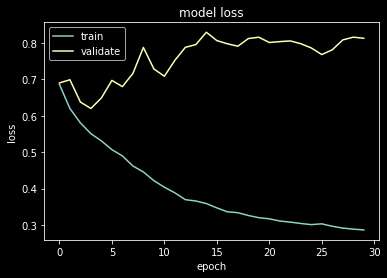

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

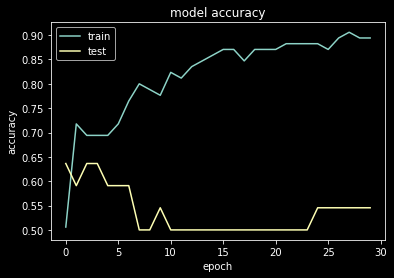

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [36]:
train_predict = model.predict(X_train_modified)
train_real_predict = np.argmax(train_predict, axis=1)+1
for i in range(len(y_train)):
    print(f"Index:{i}, Predict:{train_real_predict[i]}, Real:{y_train[i]}")

Index:0, Predict:1, Real:1
Index:1, Predict:1, Real:2
Index:2, Predict:2, Real:2
Index:3, Predict:2, Real:2
Index:4, Predict:1, Real:1
Index:5, Predict:2, Real:2
Index:6, Predict:2, Real:2
Index:7, Predict:1, Real:1
Index:8, Predict:2, Real:2
Index:9, Predict:1, Real:2
Index:10, Predict:2, Real:2
Index:11, Predict:1, Real:1
Index:12, Predict:2, Real:2
Index:13, Predict:2, Real:2
Index:14, Predict:2, Real:2
Index:15, Predict:1, Real:1
Index:16, Predict:1, Real:1
Index:17, Predict:1, Real:1
Index:18, Predict:2, Real:2
Index:19, Predict:1, Real:1
Index:20, Predict:1, Real:1
Index:21, Predict:2, Real:2
Index:22, Predict:2, Real:2
Index:23, Predict:1, Real:1
Index:24, Predict:1, Real:1
Index:25, Predict:1, Real:1
Index:26, Predict:2, Real:2
Index:27, Predict:2, Real:2
Index:28, Predict:1, Real:1
Index:29, Predict:1, Real:1
Index:30, Predict:1, Real:1
Index:31, Predict:1, Real:2
Index:32, Predict:2, Real:1
Index:33, Predict:2, Real:2
Index:34, Predict:2, Real:2
Index:35, Predict:2, Real:2
In

              precision    recall  f1-score   support

           1       0.76      0.94      0.84        51
           2       0.93      0.73      0.82        56

    accuracy                           0.83       107
   macro avg       0.85      0.84      0.83       107
weighted avg       0.85      0.83      0.83       107

----------------------------------------------


<AxesSubplot:>

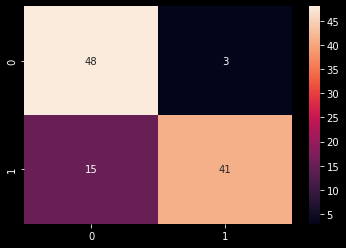

In [37]:
f1_train = f1_score(y_train, train_real_predict)
accuracy_train = accuracy_score(y_train, train_real_predict)
# print(f"f1: {f1_train}\naccuracy: {accuracy_train}")
print(classification_report(y_train, train_real_predict))
print("----------------------------------------------")
sns.heatmap(confusion_matrix(y_train, train_real_predict),annot = True,fmt = '2.0f')

In [38]:
test_predict = model.predict(X_test_modified)
test_real_predict = np.argmax(test_predict, axis=1)+1
for i in range(len(y_test)):
    print(f"Index:{i}, Predict:{test_real_predict[i]}, Real:{y_test[i]}")

Index:0, Predict:2, Real:2
Index:1, Predict:2, Real:2
Index:2, Predict:2, Real:2
Index:3, Predict:2, Real:2
Index:4, Predict:2, Real:2
Index:5, Predict:1, Real:1
Index:6, Predict:2, Real:1
Index:7, Predict:1, Real:1
Index:8, Predict:1, Real:2
Index:9, Predict:2, Real:2
Index:10, Predict:2, Real:2
Index:11, Predict:2, Real:2
Index:12, Predict:2, Real:2
Index:13, Predict:2, Real:1
Index:14, Predict:1, Real:2
Index:15, Predict:1, Real:2
Index:16, Predict:2, Real:1
Index:17, Predict:2, Real:2
Index:18, Predict:2, Real:2


f1: 0.4000000000000001
accuracy: 0.6842105263157895
              precision    recall  f1-score   support

           1       0.40      0.40      0.40         5
           2       0.79      0.79      0.79        14

    accuracy                           0.68        19
   macro avg       0.59      0.59      0.59        19
weighted avg       0.68      0.68      0.68        19

----------------------------------------------


<AxesSubplot:>

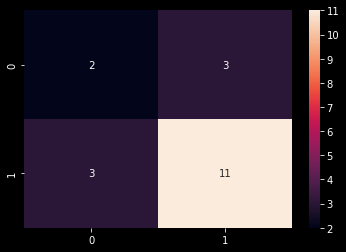

In [40]:
f1_test = f1_score(y_test, test_real_predict)
accuracy_test = accuracy_score(y_test, test_real_predict)
print(f"f1: {f1_test}\naccuracy: {accuracy_test}")
print(classification_report(y_test, test_real_predict))
print("----------------------------------------------")
sns.heatmap(confusion_matrix(y_test, test_real_predict),annot = True,fmt = '2.0f')